(examples:measurements_3d)=
# Topological skeleton analysis in 3D

In [32]:
# import 3d binary blobs
import numpy as np
import napari_toska as nts
from skimage import measure, io, morphology
import napari
import networkx as nx

import napari_segment_blobs_and_things_with_membranes as nsbatwm
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import pandas as pd

In [33]:
viewer = napari.Viewer()

In [34]:
probabilities = io.imread(r'C:\Users\johamuel\Nextcloud\Shared\Skeletons4InstanceSegmentation\Data\predicted_probabilities.tif')
segmentation = np.argmax(probabilities, axis=0)
dilated = morphology.binary_dilation(segmentation, footprint=morphology.ball(10))
segmentation_filled = ndi.binary_fill_holes(dilated > 0)
eroded = morphology.binary_erosion(segmentation_filled, footprint=morphology.ball(10))

In [35]:
labels = measure.label(eroded)
skeleton_labeled = nts.generate_labeled_skeletonization(labels)
skeleton_parsed = nts.parse_all_skeletons(skeleton_labeled, neighborhood='n26')

In [52]:
viewer.layers.clear()
viewer.add_image(probabilities[1], name='probabilities', colormap='inferno')

viewer.add_labels(labels, name='blobs')
viewer.add_labels(skeleton_labeled, name='skeleton')
viewer.add_labels(skeleton_parsed, name='parsed skeleton')

<Labels layer 'parsed skeleton' at 0x17ee41dd7f0>

In [37]:
skeleton_parsed_single = skeleton_parsed * (skeleton_labeled == 1)
viewer.add_labels(skeleton_parsed_single, name='parsed_skeleton_single')

<Labels layer 'parsed_skeleton_single' at 0x17edef99070>

In [38]:
def create_unique_skeleton(skeleton_parsed_single: "napari.types.LabelsData",
                           terminal_point_label: int = 1,
                           branch_label: int = 2,
                           junction_label: int = 3):
    
    # Get the unique semantic classes in the image (excluding background)
    semantic_classes = np.unique(skeleton_parsed_single)
    semantic_classes = semantic_classes[semantic_classes != 0]  # Exclude background
    result = np.zeros_like(skeleton_parsed_single)

    # Initialize a counter for the unique identifiers and a mapping from the identifiers to the semantic classes
    counter = 1
    mapping = {}

    # For each semantic class
    for semantic_class in semantic_classes:
        # Get a binary mask of the current semantic class
        # and label the separate entities in the mask
        mask = skeleton_parsed_single == semantic_class
        labeled = measure.label(mask)
        num_labels = np.max(labeled)

        # For each label
        for label in range(1, num_labels + 1):
            # Assign the current counter value to the current label in the result
            # and Store the mapping from the current counter value to the current semantic class
            result[labeled == label] = counter
            mapping[counter] = semantic_class

            # Increment the counter
            counter += 1

        df = pd.DataFrame(list(mapping.items()), columns=['label', 'component'])
    # insert entry for background at the top of the df
    return result, df

In [39]:
unique_skeleton, df = create_unique_skeleton(skeleton_parsed_single)

# calculate branch lengths
LUT = np.arange(0, df.shape[0]+1)
for i, row in df.iterrows():
    if row['component'] != 2:
        LUT[row['label']] = 0
        
labeled_branches_single = LUT[unique_skeleton]

branch_lengths = nts.calculate_branch_lengths(labeled_branches_single)
df = df.merge(branch_lengths, on='label', how='left')
df.fillna(0, inplace=True)

# calculate inverse length
df['inverse_length'] = 1 / df['branch_length']

In [53]:
viewer.add_labels(unique_skeleton, name='unique_skeleton', features=df)

<Labels layer 'unique_skeleton' at 0x17f3bd2bca0>

Napari status bar display of label properties disabled because https://github.com/napari/napari/issues/5417 and https://github.com/napari/napari/issues/4342
Selected column component
Selected column branch_length


In [41]:
# now we turn all this information into an nx graph
graph = nx.Graph()

for i, row in df[df['component'] != 2].iterrows():
    graph.add_node(row['label'], **row.to_dict())

# browsing all branches for connections
structure = np.ones((3, 3, 3))  # 26-connectivity
touched_objects = []
for branch_label in df[df['component'] == 2]['label']:
    branch_mask = unique_skeleton == branch_label
    expanded = ndi.binary_dilation(branch_mask, structure=structure, iterations=1)
    touched_labels = list(np.unique(expanded * unique_skeleton))

    # remove 0 and the branch label itself
    touched_labels.remove(0)
    touched_labels.remove(branch_label)

    # store for branch which labels it touches
    df.loc[df['label'] == branch_label, 'touches_1'] = touched_labels[0]
    df.loc[df['label'] == branch_label, 'touches_2'] = touched_labels[1]

    touched_objects.append(touched_labels[0])
    touched_objects.append(touched_labels[1])

    # add edges to the graph
    branch_properties = df[df['label'] == branch_label].squeeze().to_dict()
    branch_properties = {k: v for k, v in branch_properties.items() if v != 0}
    graph.add_edge(touched_labels[0], touched_labels[1], **branch_properties)


# checking for untouched objects (i.e., objects that are not connected to any branch such as end points attached to a branch point)
untouched_objects = np.setdiff1d(df[df['component'] != 2]['label'].values, touched_objects)
untouched_objects = untouched_objects[untouched_objects != 0]
for untouched in untouched_objects:
    mask = unique_skeleton == untouched
    expanded = ndi.binary_dilation(mask, structure=structure, iterations=1)
    touched_labels = list(np.unique(expanded * unique_skeleton))

    touched_labels.remove(0)
    touched_labels.remove(untouched)

    graph.add_edge(touched_labels[0], untouched, branch_length=0, label=None)

## Community separation

In [60]:
communities = nx.community.louvain_communities(graph, weight='inverse_length', resolution=0.05)

# add community as feature to nodes
for comm_index, community in enumerate(communities):
    for node in list(community):
        # add community index as feature
        graph.nodes[node]['community'] = comm_index

# add community as feature to edges
for edge in graph.edges:
    edge_data = graph.get_edge_data(*edge)
    
    #check if both nodes belong to same community
    if graph.nodes[edge[0]]['community'] == graph.nodes[edge[1]]['community']:
        edge_data['community'] = graph.nodes[edge[0]]['community']
    else:
        edge_data['community'] = np.nan

C:\Users\johamuel\AppData\Local\Temp\ipykernel_10532\4030707175.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm_edge = plt.cm.get_cmap('viridis')
C:\Users\johamuel\AppData\Local\Temp\ipykernel_10532\4030707175.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm_node = plt.cm.get_cmap('tab20')


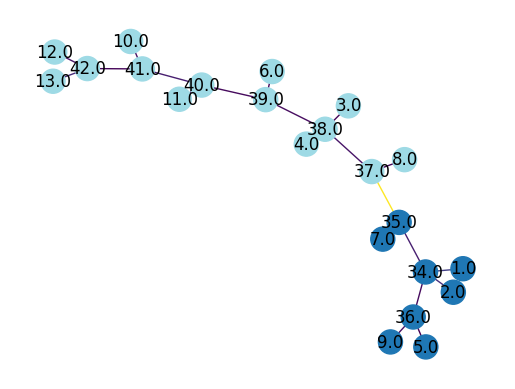

In [61]:

edge_values = [x for x in nx.get_edge_attributes(graph, 'branch_length').values()]
node_values = [graph.nodes[node]['community'] for node in graph.nodes]

cm_edge = plt.cm.get_cmap('viridis')
cm_node = plt.cm.get_cmap('tab20')
norm_edge = plt.Normalize(vmin=min(edge_values), vmax=max(edge_values))
norm_node = plt.Normalize(vmin=min(node_values), vmax=max(node_values))
edge_colors = [cm_edge(norm_edge(value)) for value in edge_values]
node_colors = [cm_node(norm_node(value)) for value in node_values]

fig, ax = plt.subplots()
# draw graph with edge weights
pos = nx.spring_layout(graph)
nx.draw(graph, pos, ax=ax, with_labels=True, edge_color=edge_colors, node_color=node_colors)

## Add community to unique skeleton

In [64]:
# retrieve the communities from the graph
communities = nx.get_node_attributes(graph, 'community')

# retrieve edges inside community for all detected communities
edges = []
for community in set(communities.values()):
    edges.append([(u, v) for u, v in graph.edges if communities[u] == community and communities[v] == community])
    edge_labels = [int(graph.nodes[u]['label']) for u, v in edges[-1]]

In [65]:
for community in list(set(communities.values())):
    node_list = [int(graph.nodes[node]['label']) for node in graph.nodes if graph.nodes[node]['community'] == community]
    edge_list = []
    for edge in graph.edges:
        if graph.edges[edge]['community'] == community and graph.edges[edge]['label'] is not None:
            edge_list.append(graph.edges[edge]['label'])

    df.loc[df['label'].isin(node_list), 'community'] = community + 1
    df.loc[df['label'].isin(edge_list), 'community'] = community + 1

df.head()

,label,component,branch_length,inverse_length,touches_1,touches_2,community
0,1,1,0.0,inf,NaN,NaN,1.0
1,2,1,0.0,inf,NaN,NaN,1.0
2,3,1,0.0,inf,NaN,NaN,2.0
3,4,1,0.0,inf,NaN,NaN,2.0
4,5,1,0.0,inf,NaN,NaN,1.0


## Cut skeleton by community

In [66]:
community_skeleton = np.zeros_like(unique_skeleton)
for i, row in df.iterrows():

    if ~np.isnan(row['community']):
        community_skeleton[unique_skeleton == row['label']] = row['community']
expanded_community = nsbatwm.expand_labels(community_skeleton, distance=100)
expanded_community = expanded_community * (eroded > 0)


In [67]:
#viewer.layers.clear()
viewer.add_labels(segmentation, blending='additive', name='segmentation')
viewer.add_labels(unique_skeleton, name='unique_skeleton', features=df, blending='additive')
viewer.add_labels(community_skeleton, name='community_skeleton', blending='additive')
viewer.add_labels(expanded_community, name='expanded_community', blending='additive')

<Labels layer 'expanded_community [1]' at 0x17f3bc90d90>

In [58]:
edt = ndi.distance_transform_edt(eroded)
edt_branch = edt * (unique_skeleton == 17)

minimum = edt_branch[edt_branch > 0].min()

edt_branch_cut = edt_branch.copy()
edt_branch_cut[edt_branch_cut == minimum] = 0

In [49]:
viewer.add_points(np.stack(np.where(edt_branch == minimum)).squeeze())

<Points layer 'Points' at 0x17edf2c87f0>

In [54]:

viewer.add_image(edt_branch, name='distance transform branch', colormap='inferno', blending='additive')
viewer.add_image(edt, name='distance transform', colormap='inferno', blending='additive')
viewer.add_image(edt_branch_cut, name='distance transform branch (cut)', colormap='inferno', blending='additive')

<Image layer 'distance transform branch (cut)' at 0x17edecbfe80>

(array([34., 13., 20.,  5., 18.]),
 array([32.34192326, 36.47353861, 40.60515395, 44.7367693 , 48.86838465,
        53.        ]),
 <BarContainer object of 5 artists>)

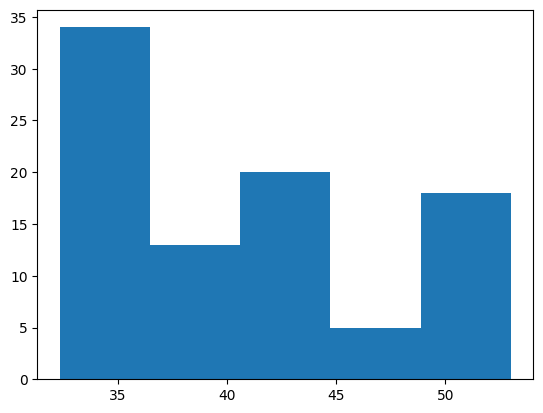

In [59]:
plt.hist(edt_branch[edt_branch != 0], bins='fd')

In [57]:
edt_branch[edt_branch != 0]

array([39.])